# Sampling from the von Mises - Fisher distribution

The von Mises - Fisher distribution is a probability distribution on the surface of a unit hypersphere of N dimensions: 

<div><center>
    $f_N(x ; \mu, \kappa)$
<center></div>

Where:
* $\mu$ is the mean direction 
* $\kappa$ is the concentration parameter

Wikipedia page: https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution 

Code used in this example is based on [this](https://stats.stackexchange.com/questions/156729/sampling-from-von-mises-fisher-distribution-in-python) and [this](https://github.com/clara-labs/spherecluster/blob/develop/spherecluster/util.py).

In [2]:
%matplotlib inline
import numpy as np
from sphere import *

## For ${\rm I\!R}^3$

For N = 3 dimensions, the von Mises - Fisher distribution is defined on the surface of a sphere.

In [3]:
# specify mu as a some 3D vector
mu = [2, -2, 3]

# normalise to a unit vector 
norm = np.linalg.norm(mu)
mu = mu / norm
print ('average direction:', mu)

# sampling
num_samples = 500
kappa = [1, 10, 100]

average direction: [ 0.48507125 -0.48507125  0.72760688]


In [4]:
# sample from vMF for a range of kappa
samples = []
for k in kappa:
    samples.append(Sphere().sample(num_samples, distribution = 'vMF', 
                                   mu = mu, kappa = k))

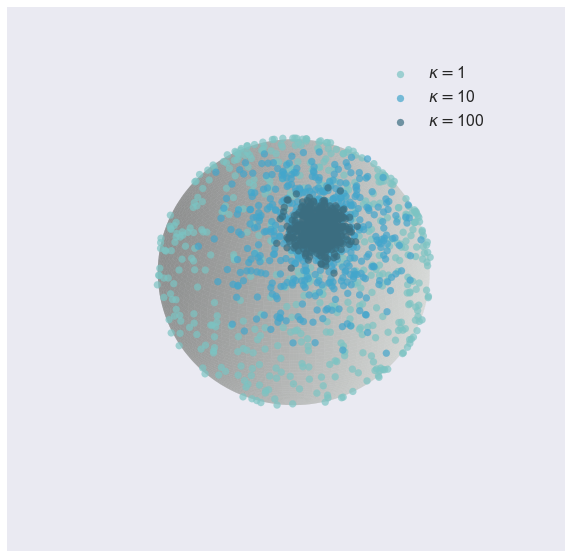

In [5]:
# plot points on the unit sphere
Sphere().plot(data = samples)

## Sampling uniformly over the sphere

To contrast, consider a sampler which draws points uniformly on the spherical shell. See [here](http://mathworld.wolfram.com/SpherePointPicking.html) for different implementations.

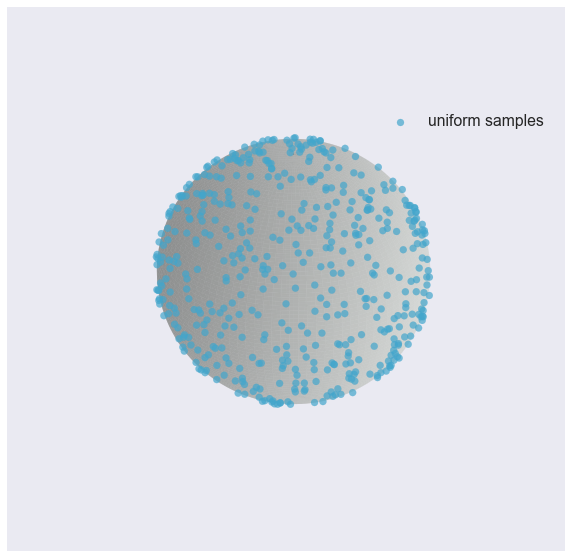

In [6]:
# sample uniformly over a unit sphere
samples = Sphere().sample(num_samples)
Sphere().plot(data = samples)

## Simulation in Stan

Using the vMF_rng defined in `vMF.stan`.

In [25]:
import pystan
simulation = pystan.StanModel(file = 'vMF_sim.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d9b026487a63da86a155a5725b75668 NOW.


In [20]:
# Use stan to simulate draws from the vMF
kappa = [1, 10, 100]
samples = []
for k in kappa:
    simu_parameters = {'N' : num_samples,
                       'mu' : mu,
                       'kappa' : k}

    simu = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                               iter = 1, chains = 1, seed = 19920715)

    sample = simu.extract(['vMF_samples'])['vMF_samples'][0]
    samples.append(vMFSample(sample, k))

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


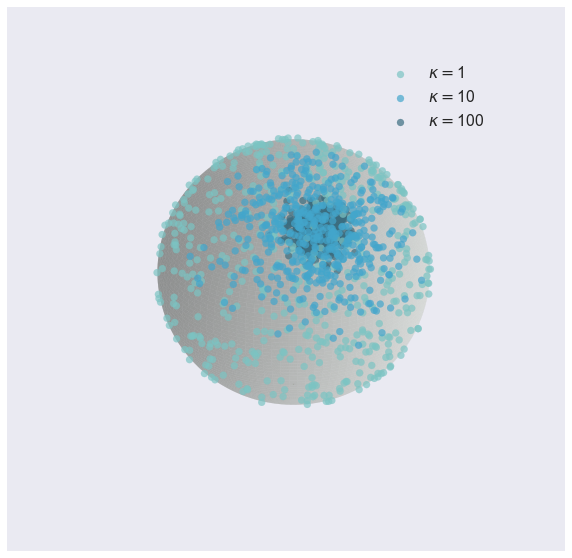

In [21]:
Sphere().plot(data = samples)

## Fitting the data in Stan

Use a simple model to infer $\mu$ and $\kappa$ from vMF samples. The model is defined in `vMF_model.stan` and uses the vMF_lpdf defined in `vMF.stan`. Check with simulated data from both python and stan.

In [42]:
# set kappa
k = 100

In [43]:
# simulate some data in stan
simu_parameters = {'N' : num_samples,
                       'mu' : mu,
                       'kappa' : k}

simu = simulation.sampling(data = simu_parameters, algorithm = "Fixed_param", 
                               iter = 1, chains = 1, seed = 19920715)

sample_stan = simu.extract(['vMF_samples'])['vMF_samples'][0]

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [44]:
# simulate some data in python
sample_python = Sphere().sample(num_samples, distribution = 'vMF', 
                         mu = mu, kappa = k).sample

In [33]:
# compile the model
model = pystan.StanModel(file = 'vMF_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a04cb5b198062961bda74b0e6274c12f NOW.


In [45]:
# fit whichever data you prefer
sample = sample_stan
#sample = sample_python

data = {'N' : len(sample), 'd' : sample}
fit = model.sampling(data = data, seed = 19920715)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [46]:
print(fit)

# compare with true values
print('\ntrue mu:', mu)
print('true kappa:', k)

Inference for Stan model: anon_model_a04cb5b198062961bda74b0e6274c12f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]   0.48  6.1e-5 3.8e-3   0.47   0.48   0.48   0.48   0.49   3928    1.0
mu[1]  -0.49  6.3e-5 3.9e-3  -0.49  -0.49  -0.49  -0.48  -0.48   3820    1.0
mu[2]   0.73  4.8e-5 3.0e-3   0.72   0.73   0.73   0.73   0.74   4000    1.0
kappa 104.37    0.15   4.63  95.51 101.07 104.36 107.54 113.49   1009    1.0
lp__   907.6    0.06   1.64  903.5 906.76 907.88 908.77 909.96    708   1.01

Samples were drawn using NUTS at Tue Jun  5 19:45:47 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

true mu: [ 0.48507125 -0.48507125  0.72760688]
true kappa: 100


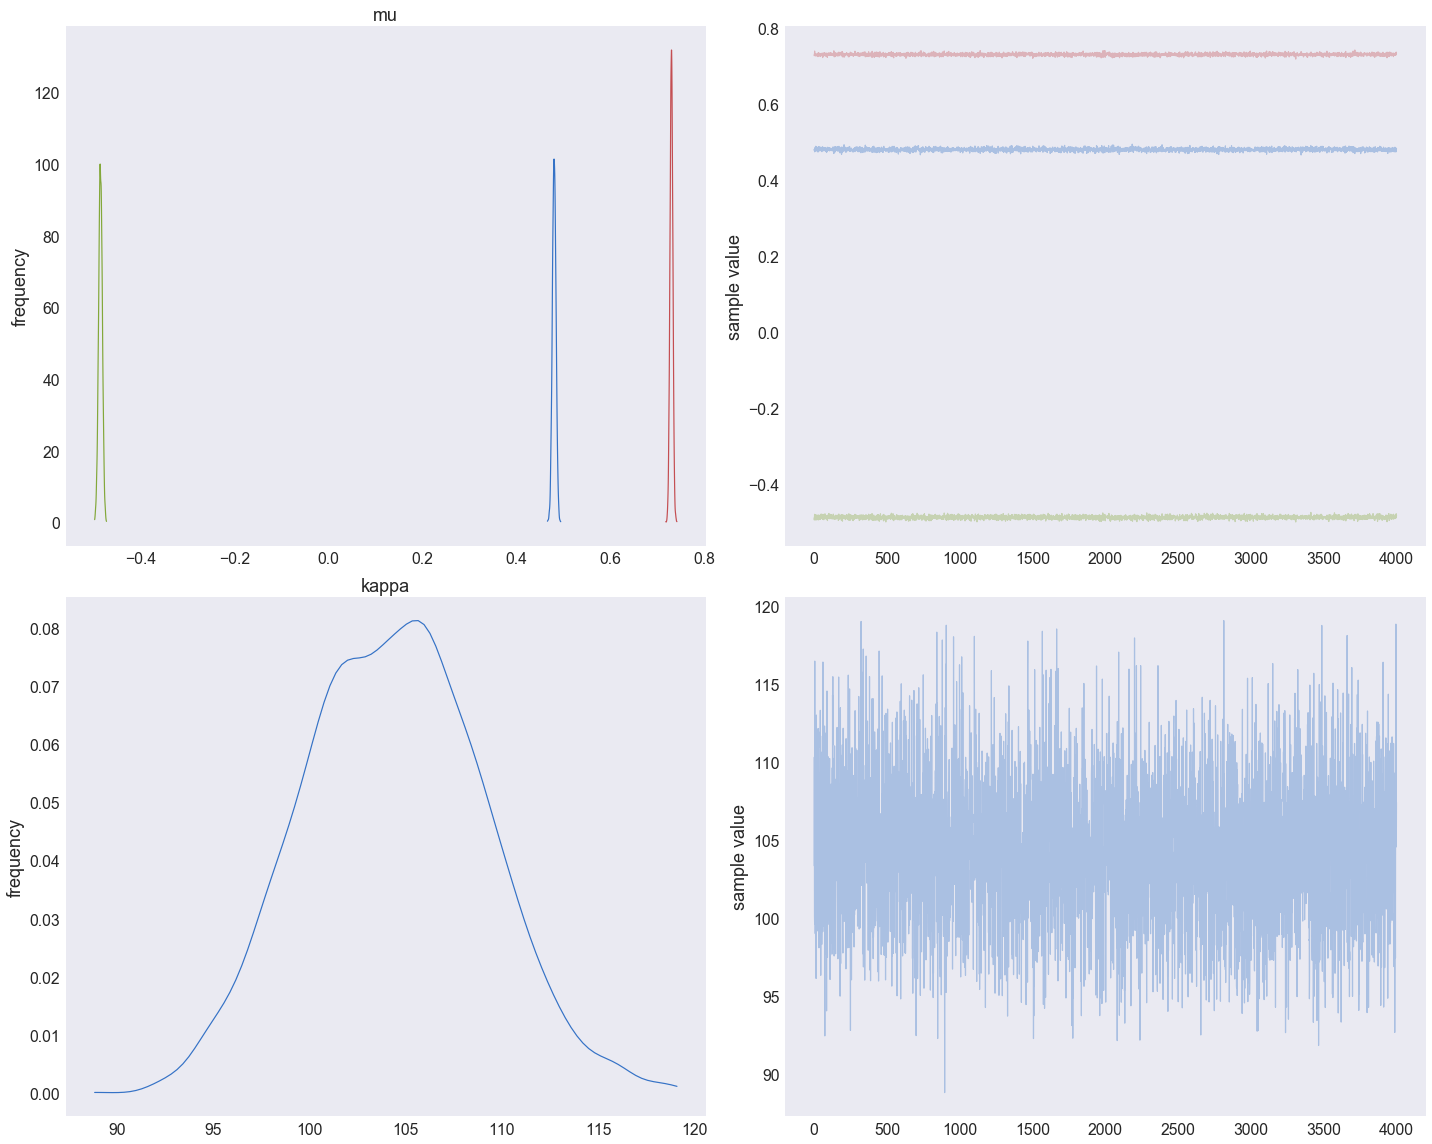

In [47]:
fig = fit.plot();
fig.set_size_inches(20, 16)
fig.tight_layout()